# 📊 Marketing Campaign Analysis and A/B Testing 

---

**Objective:** Analyze the effectiveness of 3 different marketing campaigns (A, B, C) across multiple stores and customer segments over 4 weeks.

**Key Questions:**
- Are the groups balanced in terms of location, store size, and historical performance?
- Which campaign has the highest conversion rate and revenue per customer?
- Are differences statistically significant?

## Table of contents

- 1. Simulation Context & Data Description
- 2. Data Preparation
- 3. Group Balance Check
- 4. KPI Creation
- 5. Exploratory Data Analysis (EDA)
- 6. Statistical Testing (ANOVA, Z-test, Post-hoc)
- 7. Segmented Analysis (store, customer, gender...)
- 8. Final Insights & Recommendations


## 1. Simulation Context & Data Description

### 1.1. Simulation Context

This dataset simulates a real-world A/B/C test scenario for a retail clothing chain that is launching a **New Collection**.

#### 1.1. Objective
Evaluate the effectiveness of three different **marketing campaigns** across store locations, based on customer behavior and revenue performance.

#### 1.2. Store Setup
- **150 stores** randomly assigned to one of three campaigns (**A**, **B**, **C**)
- Stratified by:
  - `store_location`: Urban / Suburban / Rural
  - `store_size_category`: Small / Medium / Large
- Store-level attributes include:
  - `avg_revenue_last_3_months`
  - `monthly_active_customers`

#### 1.3. Customer Simulation
- Approx. **30,000 customers** interacted across **4 weeks**
- Each customer is assigned to only one store
- Only customers with **at least one purchase** are included
- Weekly records include:
  - `visit_count`, `products_ord`, `new_collection_items`, `revenue`
  - Demographics: `age`, `gender`
  - Promotion usage and gift received if eligible

#### 1.4. Campaign Summary
- **Campaign A**: 5% discount on the total bill (requires at least one New Collection item)
- **Campaign B**: Free gift with the purchase of any New Collection item
- **Campaign C**: Email/SMS announcement + 10% discount via loyalty points or voucher

This dataset is designed to support analysis such as A/B testing, segmentation, behavioral trends, and campaign performance evaluation.


### 1.2. Dataset Description

This dataset simulates a 4-week A/B/C marketing experiment run by a retail clothing chain to evaluate the effectiveness of three different promotional strategies for a new product collection. Only customers who made at least one purchase are included.

Each customer is assigned to one store (with a fixed campaign) and the dataset includes rich demographic, store-level, and transactional information.

#### 🧷 Columns Overview

| Column Name                 | Description                                                                 |
|-----------------------------|-----------------------------------------------------------------------------|
| `customer_id`               | Unique ID for each customer                                                 |
| `week`                      | Week number of the transaction (1 to 4)                                     |
| `store_id`                  | Unique ID of the store visited                                              |
| `campaign_group`            | Type of marketing campaign assigned to the store: A, B, or C                |
| `store_location`            | Store’s geographical location (`Urban`, `Suburban`, `Rural`)                |
| `store_size_category`       | Store size classification (`Small`, `Medium`, `Large`)                      |
| `avg_revenue_last_3_months` | Average revenue of the store prior to the campaign                          |
| `monthly_active_customers`  | Average number of monthly active customers at the store                     |
| `customer_segment`          | Type of customer (`New`, `Returning`)                                       |
| `age`                       | Age of the customer (only for purchasing customers)                         |
| `gender`                    | Gender of the customer (`Male`, `Female`)                                   |
| `visit_count`               | Number of visits resulting in a purchase during the week                    |
| `products_ord`              | Total number of products purchased                                          |
| `new_collection_items`      | Number of items from the new collection purchased                           |
| `other_products_ord`        | Number of products outside the new collection                               |
| `discount`                  | Discount rate applied (0%, 5%, or 10%)                                      |
| `gift_received`             | Gift received (if campaign B & eligible), else blank                        |
| `used_loyalty_or_voucher`   | Whether loyalty points/voucher was applied (for campaign C)                 |
| `promo_used`                | Whether any promo was used (gift or discount)                               |
| `revenue_before_discount`   | Original order value before applying discount                               |
| `revenue`                   | Final order revenue after discount                                          |


## 2. Data Preparation

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')

In [23]:
df = pd.read_csv('ab_marketing_campaign_stratified.csv')
df.head()

,customer_id,week,store_id,campaign_group,store_location,store_size_category,avg_revenue_last_3_months,monthly_active_customers,customer_segment,age,...,products_ord,new_collection_items,other_products_ord,discount,gift_received,used_loyalty_or_voucher,promo_used,revenue_before_discount,revenue,used_new_collection
0,2,1,S141,A,Rural,Small,156279.0,2761,Returning,18.0,...,3,0,3,0.00,NaN,False,No,257.339184,257.34,False
1,3,1,S118,A,Urban,Medium,114664.0,2219,Returning,22.0,...,5,1,4,0.05,NaN,False,Yes,456.174741,433.37,True
2,4,1,S057,A,Urban,Small,127025.0,1380,Returning,18.0,...,3,1,2,0.05,NaN,False,Yes,240.945008,228.90,True
3,6,1,S105,A,Rural,Small,99363.0,2600,New,19.0,...,5,1,4,0.05,NaN,False,Yes,314.321130,298.61,True
4,8,1,S107,C,Suburban,Large,130323.0,704,Returning,18.0,...,5,0,5,0.00,NaN,False,No,84.453205,84.45,False


## 3. Group Balance Check

### Why Perform Group Balance Check?

Before comparing outcomes across different groups in an A/B/C test, it's essential to verify that the groups are balanced in terms of key characteristics. Otherwise, observed differences might be due to pre-existing differences — not the effect of the campaign.

#### Reasons to Perform Balance Check

1. **Ensure Fair Comparison**
   - If groups differ in demographics, location, or store size, any observed revenue differences might be biased.

2. **Support Valid Statistical Testing**
   - Most statistical tests assume that groups are similar in underlying characteristics.
   - Unbalanced groups can lead to misleading p-values (false positives or negatives).

3. **Detect Hidden Bias**
   - Example: Group B has mostly returning customers, Group C has mostly new customers → result is influenced by customer loyalty, not the campaign.

---

#### Steps

1. **Visual Checks**
   - Bar charts / Boxplots for variables like:
     - `store_location`, `store_size_category`
     - `age`, `gender`, `customer_segment`
     - `avg_revenue_last_3_months`, `monthly_active_customers`

2. **Statistical Tests**
   - **Chi-squared test** for categorical variables
   - **ANOVA / Kruskal-Wallis test** for numerical variables

3. **Document Any Imbalance**
   - If significant imbalance exists, consider:
     - Controlling for those variables in later analysis (e.g., regression)
     - Stratifying results or filtering

---

> A balance check helps ensure that any differences in campaign outcomes are **due to the campaign itself**, not underlying group biases.

### 3.1. Store balance checks

#### Store Location Distribution by Campaign

In [24]:
pd.crosstab(df['campaign_group'], df['store_location'])

store_location,Rural,Suburban,Urban
campaign_group,,,
A,6784,9787,13435
B,4026,6350,9160
C,2238,3811,5367


- The Rural/Suburban/Urban ratio between groups is not too different. 
- Small differences (less than 10%) between groups are acceptable in the context of real-life simulation data.

#### Store Size Category Distribution by Campaign

In [25]:
pd.crosstab(df['campaign_group'], df['store_size_category'])

store_size_category,Large,Medium,Small
campaign_group,,,
A,6481,14549,8976
B,4417,9575,5544
C,2100,5772,3544


- Medium stores account for about 50% of all three groups. 
- The difference between the groups is very small, so it does not affect the A/B test results.

#### Baseline Revenue Distribution

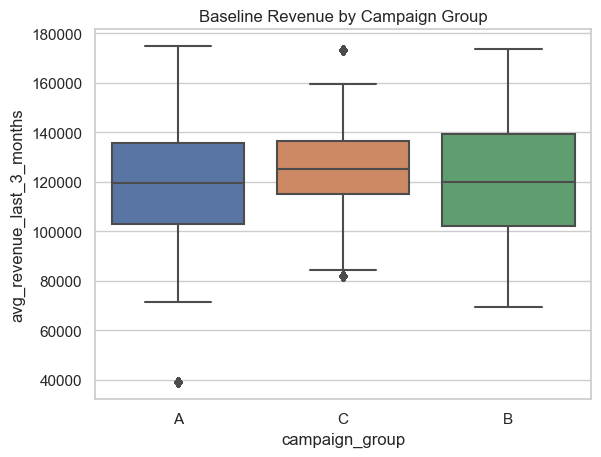

In [27]:
# Distribution of baseline revenue and customer demographics
sns.boxplot(x='campaign_group', y='avg_revenue_last_3_months', data=df)
plt.title('Baseline Revenue by Campaign Group')
plt.show()

- The distribution of average revenue over the past 3 months among groups A, B, and C is quite even.

- There are no significant differences in medians, quartiles, or outliers among groups.

> ✅ Conclusion: Data has been allocated reasonably between A/B/C groups → Ensure group balance requirements for A/B tests, reducing the risk of bias from store-side noise variables.

### 3.2. Demographic checks + Chi-Square

> Gender Distribution per Campaign

In [28]:
# Count distribution
gender_ct = pd.crosstab(df['campaign_group'], df['gender'])
display(gender_ct)

# Chi-square test
from scipy.stats import chi2_contingency
chi2_gender = chi2_contingency(gender_ct)
print(f"Chi-square p-value (Gender vs Campaign): {chi2_gender[1]:.4f}")

gender,Female,Male
campaign_group,,
A,15048,14958
B,9721,9815
C,5695,5721


Chi-square p-value (Gender vs Campaign): 0.6816


- Chi-square p-value = 0.6816 → there is no significant difference in gender distribution between campaign groups.

- Conclusion: The gender ratio between the 3 groups A-B-C is balanced, no adjustment is needed.

>  Age Distribution (Visual + ANOVA)

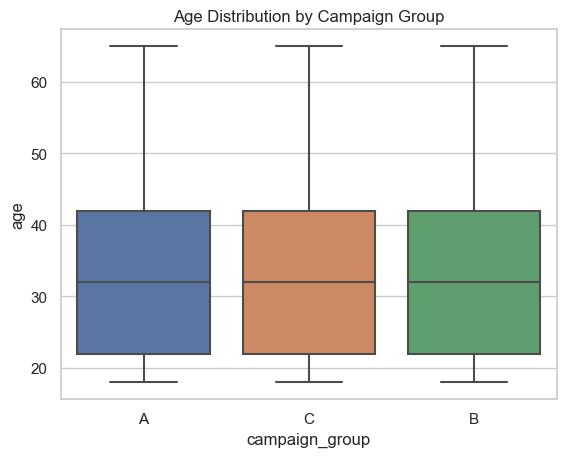

ANOVA p-value (Age vs Campaign): 0.1083


In [30]:
# Boxplot
sns.boxplot(x='campaign_group', y='age', data=df)
plt.title("Age Distribution by Campaign Group")
plt.show()

# ANOVA test
from scipy.stats import f_oneway
group_A = df[df['campaign_group'] == 'A']['age']
group_B = df[df['campaign_group'] == 'B']['age']
group_C = df[df['campaign_group'] == 'C']['age']
anova_age = f_oneway(group_A, group_B, group_C)
print(f"ANOVA p-value (Age vs Campaign): {anova_age.pvalue:.4f}")

- Boxplot shows that the age distribution of the 3 groups is quite similar, no group has a clear difference.

- ANOVA p-value = 0.1083 (> 0.05) → there is no statistically significant difference in age between groups.

> ✅ Conclusion: This is an extremely important step to ensure that the A/B test results are reliable and not biased by background factors.

## 4. KPI Creation

> Why need KPI Creation?

- Creating quantitative metrics to evaluate and compare the effectiveness of each campaign group according to specific criteria.

> 3 KPI criteria include:

* Engagement & Conversion

* Revenue & Promotion

* Promotion Effectiveness

### 4.1. Calculate KPI by campaign_group

In [67]:
df.describe()

,customer_id,week,avg_revenue_last_3_months,monthly_active_customers,age,visit_count,products_ord,new_collection_items,other_products_ord,discount,revenue_before_discount,revenue,revenue_per_visit
count,60958.000000,60958.000000,60958.000000,60958.000000,60958.000000,60958.000000,60958.000000,60958.000000,60958.000000,60958.000000,60958.000000,60958.000000,60958.000000
mean,15045.650120,2.497933,121015.122232,1706.374373,33.390318,1.501509,3.004478,0.617917,2.386561,0.016940,195.776262,191.388667,143.242852
std,8655.174953,1.116823,23966.103729,757.559264,12.592078,0.500002,1.415244,0.803820,1.351439,0.025536,125.431384,121.071934,106.639726
min,2.000000,1.000000,38968.000000,509.000000,18.000000,1.000000,1.000000,0.000000,0.000000,0.000000,10.000000,9.000000,4.500000
25%,7542.250000,1.000000,103667.000000,1017.000000,22.000000,1.000000,2.000000,0.000000,1.000000,0.000000,89.810092,88.792500,62.540000
50%,15074.000000,2.000000,120315.000000,1644.000000,32.000000,2.000000,3.000000,0.000000,2.000000,0.000000,173.619879,170.570000,114.940000
75%,22547.000000,3.000000,136553.000000,2468.000000,42.000000,2.000000,4.000000,1.000000,3.000000,0.050000,279.162640,272.790000,195.760000
max,30000.000000,4.000000,174745.000000,2997.000000,65.000000,2.000000,5.000000,5.000000,5.000000,0.100000,600.000000,600.000000,600.000000


In [69]:
# Calculate KPI by campaign_group
kpi_df = df.groupby('campaign_group').agg(
    total_customers=('customer_id', 'nunique'),
    total_visits=('visit_count', 'sum'),
    total_products=('products_ord', 'sum'),
    total_new_collection=('new_collection_items', 'sum'),
    total_revenue=('revenue', 'sum'),
    new_customers=('customer_segment', lambda x: (x == 'New').sum()),
    promo_used=('promo_used', lambda x: (x == 'Yes').sum()),
    revenue_by_promo=('revenue', lambda x: x[df.loc[x.index, 'promo_used'] == 'Yes'].sum())
).reset_index()

# Thêm returning_customers: = total_customers - new_customers
kpi_df['returning_customers'] = kpi_df['total_customers'] - kpi_df['new_customers']

In [65]:
kpi_df.head()

,campaign_group,total_customers,total_visits,total_products,total_new_collection,total_revenue,new_customers,returning_customers,promo_used,revenue_by_promo,...,new_collection_items_per_visit_count,new_customer_rate,revenue_per_customer,revenue_per_visit_count,revenue_per_product,revenue_per_new_collection_item,revenue_per_new_customer,revenue_per_returning_customer,promo_utilization_rate,avg_revenue_by_promo
0,A,10630,44996,90229,27086,6938192.11,2848,27158,18408,4798827.28,...,0.601965,0.267921,652.699164,154.195753,76.895367,256.154180,2436.162960,255.475076,1.731703,260.692486
1,B,9187,29415,58506,8147,3507288.04,1244,18292,6788,1451393.16,...,0.276968,0.135409,381.766413,119.234678,59.947493,430.500557,2819.363376,191.738904,0.738870,213.817496
2,C,7203,17118,34412,2434,1221190.20,421,10995,1122,134011.14,...,0.142190,0.058448,169.539109,71.339537,35.487336,501.721528,2900.689311,111.067776,0.155768,119.439519


### 4.2. KPIs for Engagement and Conversion criteria

In [70]:
kpi_df['products_ord_per_visit_count'] = kpi_df['total_products'] / kpi_df['total_visits']
kpi_df['products_ord_per_customer'] = kpi_df['total_products'] / kpi_df['total_customers']
kpi_df['share_of_new_collection'] = kpi_df['total_new_collection'] / kpi_df['total_products']
kpi_df['new_collection_items_per_customer'] = kpi_df['total_new_collection'] / kpi_df['total_customers']
kpi_df['new_collection_items_per_visit_count'] = kpi_df['total_new_collection'] / kpi_df['total_visits']
kpi_df['new_customer_rate'] = kpi_df['new_customers'] / kpi_df['total_customers']

### 4.3. KPIs for Revenue criteria

In [71]:
kpi_df['revenue_per_customer'] = kpi_df['total_revenue'] / kpi_df['total_customers']
kpi_df['revenue_per_visit_count'] = kpi_df['total_revenue'] / kpi_df['total_visits']
kpi_df['revenue_per_product'] = kpi_df['total_revenue'] / kpi_df['total_products']
kpi_df['revenue_per_new_collection_item'] = kpi_df['total_revenue'] / kpi_df['total_new_collection']
kpi_df['revenue_per_new_customer'] = kpi_df['total_revenue'] / kpi_df['new_customers']
kpi_df['revenue_per_returning_customer'] = kpi_df['total_revenue'] / kpi_df['returning_customers']

### 4.4. KPIs for Promotion Effectiveness criteria

In [72]:
kpi_df['promo_utilization_rate'] = kpi_df['promo_used'] / kpi_df['total_customers']
kpi_df['avg_revenue_by_promo'] = kpi_df['revenue_by_promo'] / kpi_df['promo_used']

### 4.5. Display KPI DataFrame

In [73]:
kpi_df[['campaign_group', 'products_ord_per_visit_count', 'products_ord_per_customer', 'share_of_new_collection',
        'new_collection_items_per_customer', 'new_collection_items_per_visit_count', 'new_customer_rate',
        'total_revenue', 'revenue_per_customer', 'revenue_per_visit_count', 'revenue_per_product',
        'revenue_per_new_collection_item', 'revenue_per_new_customer', 'revenue_per_returning_customer',
        'promo_utilization_rate', 'avg_revenue_by_promo']]

,campaign_group,products_ord_per_visit_count,products_ord_per_customer,share_of_new_collection,new_collection_items_per_customer,new_collection_items_per_visit_count,new_customer_rate,total_revenue,revenue_per_customer,revenue_per_visit_count,revenue_per_product,revenue_per_new_collection_item,revenue_per_new_customer,revenue_per_returning_customer,promo_utilization_rate,avg_revenue_by_promo
0,A,2.005267,8.488147,0.300192,2.548071,0.601965,0.267921,6938192.11,652.699164,154.195753,76.895367,256.154180,2436.162960,891.569277,1.731703,260.692486
1,B,1.988985,6.368347,0.139251,0.886797,0.276968,0.135409,3507288.04,381.766413,119.234678,59.947493,430.500557,2819.363376,441.557099,0.738870,213.817496
2,C,2.010282,4.777454,0.070731,0.337915,0.142190,0.058448,1221190.20,169.539109,71.339537,35.487336,501.721528,2900.689311,180.063433,0.155768,119.439519


## 5. Exploratory Data Analysis (EDA) by KPI Group

> EDA implementation revolves around the KPIs just created to:

- Stick to A/B testing goals on campaign effectiveness

- Clearly explain customer/store behavior associated with performance

- Prepare directly for statistical testing and segment analysis

### 5.1. Engagement & Conversion

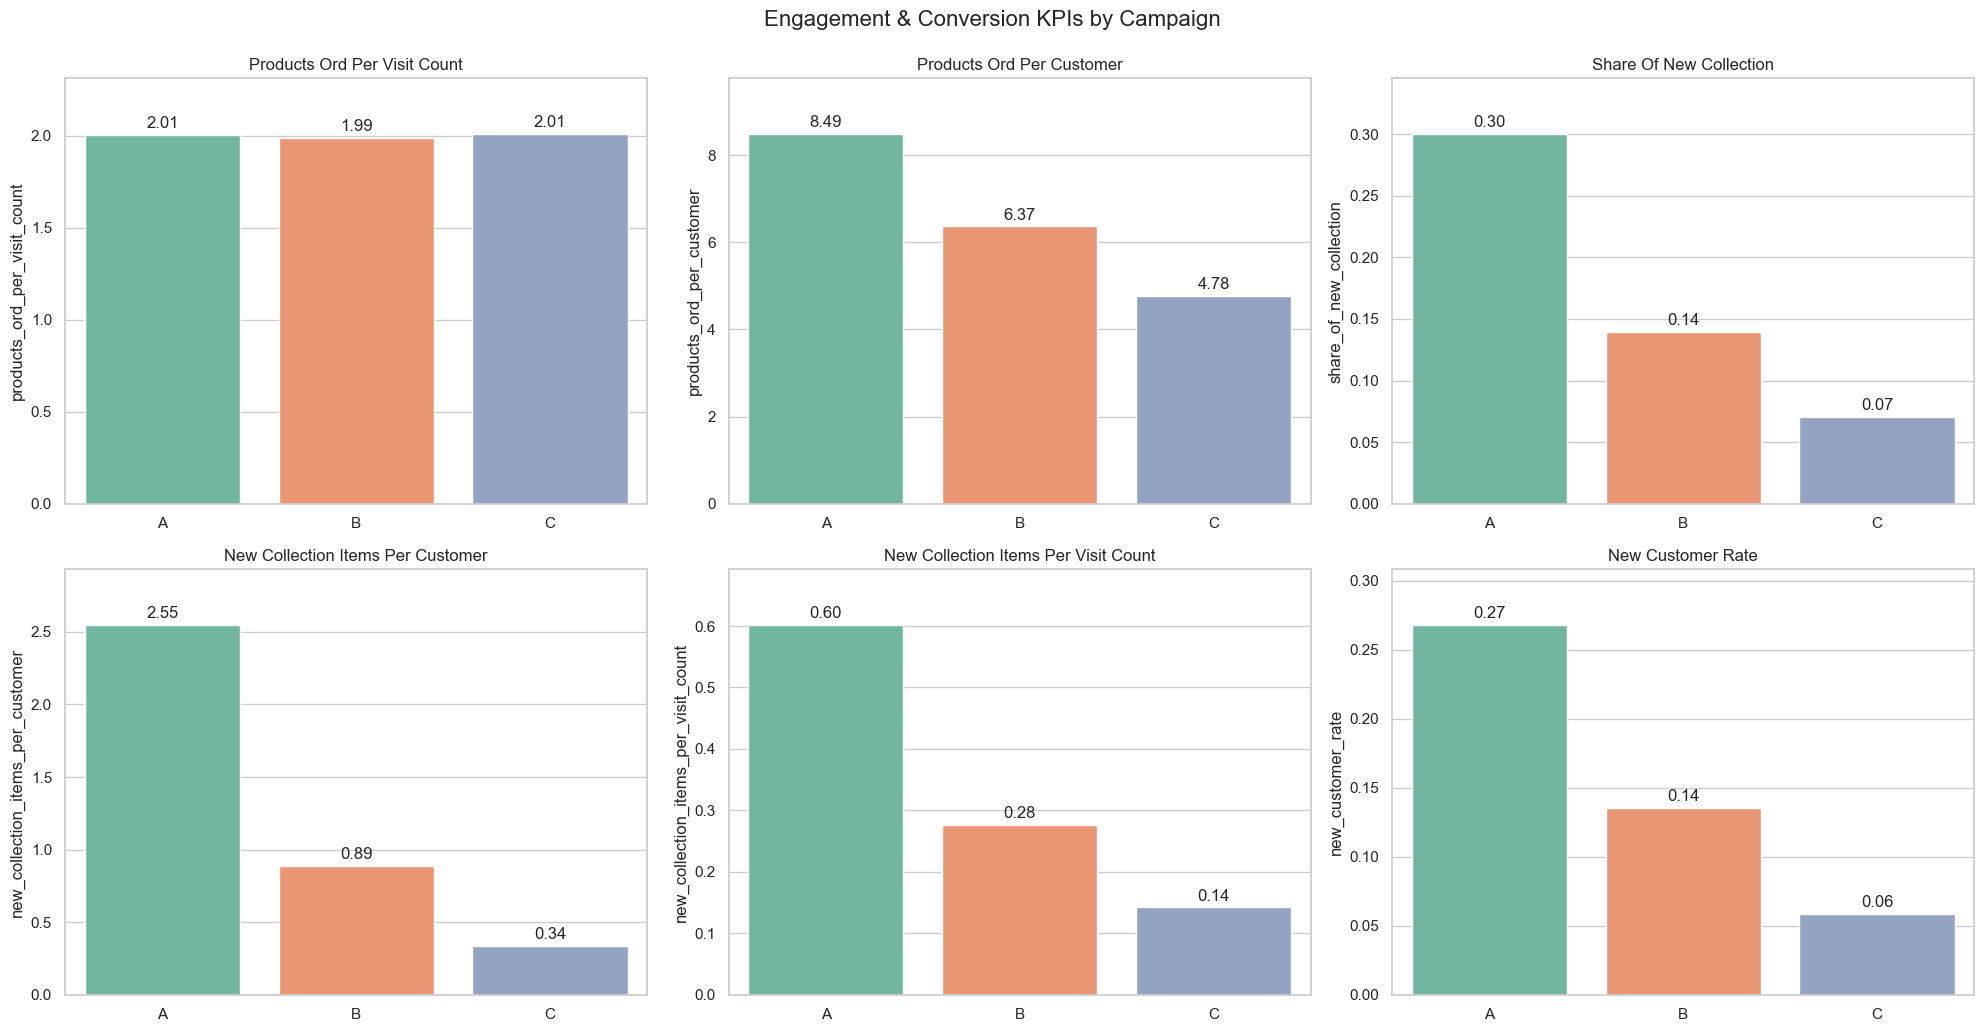

In [ ]:
engagement_metrics = [
    'products_ord_per_visit_count', 'products_ord_per_customer', 'share_of_new_collection',
    'new_collection_items_per_customer', 'new_collection_items_per_visit_count', 'new_customer_rate'
]

plt.figure(figsize=(20, 10))

for i, metric in enumerate(engagement_metrics):
    plt.subplot(2, 3, i + 1)
    ax = sns.barplot(data=kpi_df, x='campaign_group', y=metric, palette='Set2')
    plt.title(metric.replace('_', ' ').title())
    plt.xlabel('')

    # Add data labels
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height() + 0.01 * kpi_df[metric].max(), 
            f'{p.get_height():.2f}',
            ha='center',
            va='bottom',
            fontsize=12
        )

    # Optional: create space between data label and bar
    ax.set_ylim(0, kpi_df[metric].max() * 1.15)

plt.tight_layout()
plt.suptitle("Engagement & Conversion KPIs by Campaign", fontsize=16, y=1.03)
plt.show()

> Campaign A demonstrates the highest engagement and conversion performance across almost all KPIs, especially:

- New collection items per customer and per visit.

- Highest new customer rate and share of new collection items.

> Campaign C shows the lowest performance in all metrics, notably:

- Very low new customer rate (~6%) and minimal adoption of new collection products.

> Campaign B stands in the middle, delivering moderate effectiveness.

> ⚠️ Suggestion: **Campaign A seems most effective in driving new customer acquisition and new product engagement**, making it a key candidate for deeper analysis and benchmarking.

### 5.2. Revenue

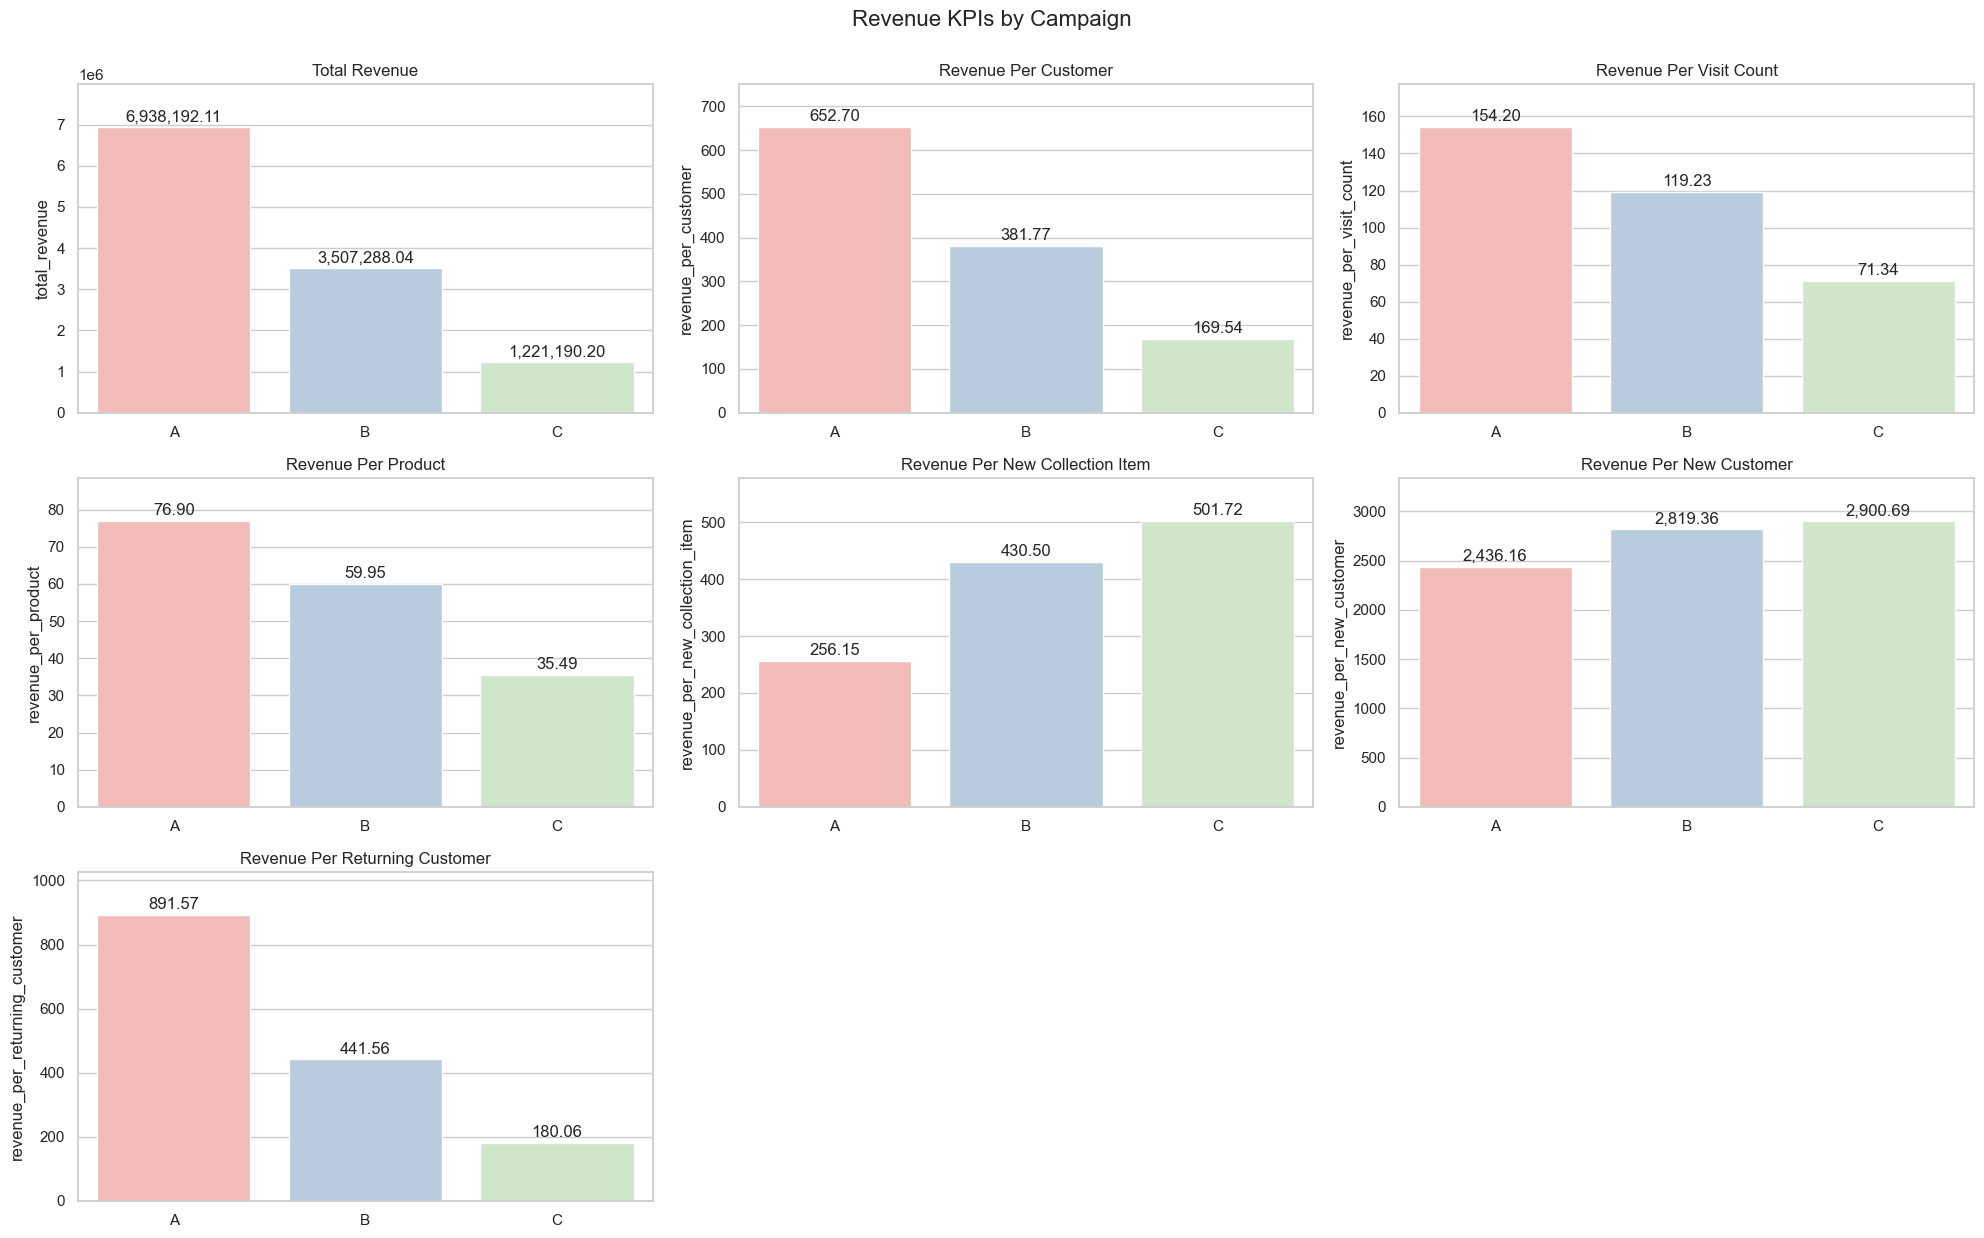

In [ ]:
revenue_metrics = [
    'total_revenue', 'revenue_per_customer', 'revenue_per_visit_count',
    'revenue_per_product', 'revenue_per_new_collection_item',
    'revenue_per_new_customer', 'revenue_per_returning_customer'
]

plt.figure(figsize=(20, 12))

for i, metric in enumerate(revenue_metrics):
    plt.subplot(3, 3, i + 1)
    ax = sns.barplot(data=kpi_df, x='campaign_group', y=metric, palette='Pastel1')
    plt.title(metric.replace('_', ' ').title())
    plt.xlabel('')

    # Add data labels
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height() + 0.01 * kpi_df[metric].max(),  # adjust spacing
            f'{p.get_height():,.2f}',  # format with comma and 2 decimals
            ha='center',
            va='bottom',
            fontsize=12
        )

    # Optional: extend Y axis for better label visibility
    ax.set_ylim(0, kpi_df[metric].max() * 1.15)

plt.tight_layout()
plt.suptitle("Revenue KPIs by Campaign", fontsize=16, y=1.03)
plt.show()

> Campaign A leads across most revenue KPIs, especially:

- Total Revenue

- Revenue per Customer and Returning Customer

- Revenue per Visit and per Product

> Campaign B ranks second overall, with strengths in:

- Revenue per Customer and Visit

- Strong efficiency with new collection items

> Campaign C shows the lowest performance overall, but stands out in:

- Highest revenue per new customer

- Highest revenue per new collection item

- This also makes sense because the rate of new customers and the rate of purchasing products in the new collection in Campaign C is the lowest among the 3 campaigns.

### 5.3. Promotion Effectiveness

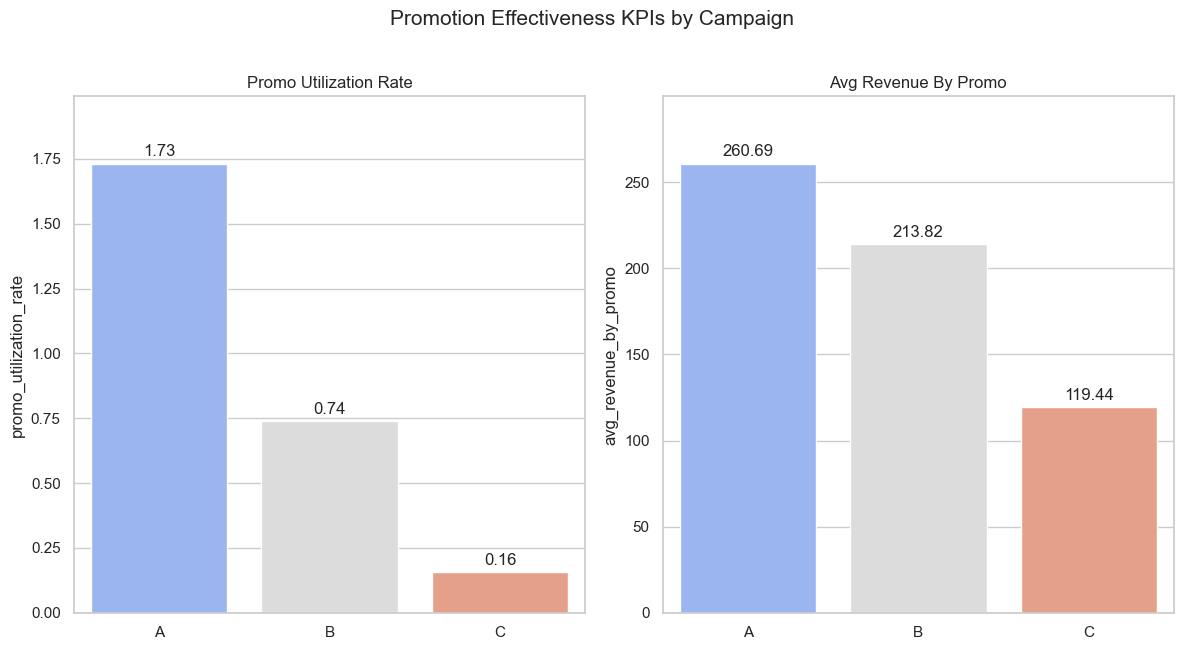

In [77]:
promotion_metrics = ['promo_utilization_rate', 'avg_revenue_by_promo']

plt.figure(figsize=(12, 6))
for i, metric in enumerate(promotion_metrics):
    plt.subplot(1, 2, i + 1)
    ax = sns.barplot(data=kpi_df, x='campaign_group', y=metric, palette='coolwarm')
    plt.title(metric.replace('_', ' ').title())
    plt.xlabel('')

    # Add data labels
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height() + 0.01 * kpi_df[metric].max(),
            f'{p.get_height():.2f}',
            ha='center',
            va='bottom',
            fontsize=12
        )

    # Adjust Y limit for label visibility
    ax.set_ylim(0, kpi_df[metric].max() * 1.15)

plt.tight_layout()
plt.suptitle("Promotion Effectiveness KPIs by Campaign", fontsize=15, y=1.08)
plt.show()

> Campaign A stands out as the most effective:

- Promo utilization rate (1.73) is over 2x B and 10x C.

- Avg revenue per promo (260.69) is also the highest, indicating strong usage and good revenue conversion from promotions.

> Campaign B performs moderately:

- Utilization and promo revenue are decent, but not as high as A.

> Campaign C underperforms significantly:

- Lowest values in both utilization (0.16) and revenue per promo (119.44).

### 5.4. Overall Conclusion & Recommendation

#### Conclusion:

> Campaign A is the most effective and well-rounded campaign, leading in:

- New customer acquisition

- Engagement with new collection items

- Revenue performance across all key metrics

- Promotion effectiveness, with the highest usage and revenue from promotions

> Campaign B performs moderately and consistently:

- Delivers solid results in new product efficiency and revenue per customer/visit

- Can serve as a supporting or control strategy

> Campaign C shows the weakest overall performance, although:

- It achieves the highest revenue per new customer and per new product

- This may indicate precise targeting but limited scale or appeal

---

#### Recommendation:

> ✅ Scale or replicate Campaign A, as it serves as the strongest model for effectiveness and can act as a benchmark for future strategies.

> 🔄 Consider refining Campaign B to push it toward higher efficiency.

> ⚠️ Reevaluate Campaign C entirely — its current structure and positioning may not align with the intended marketing goals.

## 🧪 Statistical Testing

In [ ]:
# ANOVA test for revenue
anova_model = ols('revenue ~ campaign_group', data=df).fit()
sm.stats.anova_lm(anova_model, typ=2)

In [ ]:
# Chi-square test for purchase rate
contingency_table = pd.crosstab(df['campaign_group'], df['purchase'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi2 = {chi2:.2f}, p = {p:.4f}")

## 📌 Conclusion & Recommendation
- Summarize key insights from the analysis
- Which campaign is most effective?
- Any recommendations for future rollouts?
